## Introduction
Detection of fire and smoke in CCTV footage by fire authorities can significantly increase the response time to such tragedies saving many lives. This kernel translates this task into an image regonition problem on sampled CCTV video frames. 

In [ ]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)'
import matplotlib.pyplot as plt
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from tensorflow.python.keras import optimizers


import cv2
import math
from IPython.display import clear_output
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/fire-detection-from-cctv/data/data/img_data"))
print(os.listdir("../input/fire-detection-from-cctv/data/data/video_data/test_videos"))
print(os.listdir("../input"))

print(os.listdir("../input/resnet50"))
print(os.listdir("../input/vgg16"))

# Any results you write to the current directory are saved as output.

['train', 'test']
['test2.mp4', 'test1.mp4', 'test3.mp4']
['resnet50', 'fire-detection-from-cctv', 'vgg16']
['resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 'imagenet_class_index.json', 'resnet50_weights_tf_dim_ordering_tf_kernels.h5']
['vgg16_weights_tf_dim_ordering_tf_kernels.h5', 'imagenet_class_index.json', 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5']


## Data Preparation
The CCTV footage for training and testing is downloaded from publically available videos on Youtube. The training set is prepared by sampling the videos at a constant rate and manually distributing the sampled frames into 'default', 'fire' and 'smoke' categories. Frames are kept in directories named after the class to which  they belong.

In [2]:
IMG_SIZE = 224
NUM_EPOCHS = 20
NUM_CLASSES = 3
TRAIN_BATCH_SIZE = 77
TEST_BATCH_SIZE = 1 


## Model Creation

The model is created by appending 'Dense' layer, with number of activation units equivalent to the number classes (3), to a pre-trained Reset50 model. This significantly reduces the training time.



In [3]:
def create_model( model_size ):
    my_new_model = Sequential()
    if  model_size == 'L':
        resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
        resnet = ResNet50(include_top=False, pooling='avg', weights=resnet_weights_path)
        #resnet.summary()
        my_new_model.add(resnet)
        my_new_model.layers[0].trainable = False
    else:
        vgg_weights_path = '../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
        vgg= VGG16(include_top=False, weights=vgg_weights_path ) 
        vgg.summary()
        my_new_model.add(vgg)
        my_new_model.add(GlobalAveragePooling2D())
        my_new_model.layers[0].trainable = False
        my_new_model.layers[1].trainable = False
        
    my_new_model.add(Dense(NUM_CLASSES, activation='softmax'))
   
    # Say no to train first layer (ResNet) model. It is already trained
    
    opt = optimizers.adam()
    my_new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return my_new_model

## Training

The frames for training and testing are read from the directories using ImageDataGenerator.Data augmentation is performed by horizontally flipping each image by setting the horizontal_flip to True in the ImageDataGenerator.

In [4]:
def train_model( model ):
    #ata_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

    data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                #sear_range=0.01,
                                zoom_range=[0.9, 1.25],
                                horizontal_flip=True,
                                vertical_flip=False,
                                data_format='channels_last',
                                brightness_range=[0.5, 1.5]
                               )
                                       
    train_generator = data_generator_with_aug.flow_from_directory(
            '../input/fire-detection-from-cctv/data/data/img_data/train',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=TRAIN_BATCH_SIZE,
            class_mode='categorical')
    
   
    validation_generator = data_generator_with_aug.flow_from_directory(
            '../input/fire-detection-from-cctv/data/data/img_data/test',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=TEST_BATCH_SIZE,
            shuffle = False,
            class_mode='categorical')
    
        
    #y_train = get_labels(train_generator)
    #weights = class_weight.compute_class_weight('balanced',np.unique(y_train), y_train)
    #dict_weights = { i: weights[i] for i in range(len(weights)) }
       
    H = model.fit_generator(
            train_generator,
            steps_per_epoch=train_generator.n/TRAIN_BATCH_SIZE,
            epochs=NUM_EPOCHS,
            validation_data=validation_generator,
            validation_steps=1 #,
            #class_weight=dict_weights
                )
    
    plot_history( H, NUM_EPOCHS )
    
    return model, train_generator,validation_generator

In [5]:
def get_label_dict(train_generator ):
# Get label to class_id mapping
    labels = (train_generator.class_indices)
    label_dict = dict((v,k) for k,v in labels.items())
    return  label_dict   

In [6]:
def get_labels( generator ):
    generator.reset()
    labels = []
    for i in range(len(generator)):
        labels.extend(np.array(generator[i][1]) )
    return np.argmax(labels, axis =1)

In [7]:
def get_pred_labels( test_generator):
    test_generator.reset()
    pred_vec=model.predict_generator(test_generator,
                                     steps=test_generator.n, #test_generator.batch_size
                                     verbose=1)
    return np.argmax( pred_vec, axis = 1), np.max(pred_vec, axis = 1)
    

In [8]:
def plot_history( H, NUM_EPOCHS ):
    plt.style.use("ggplot")
    fig = plt.figure()
    fig.set_size_inches(15, 5)
    
    fig.add_subplot(1, 3, 1)
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_loss"], label="val_loss")
    plt.title("Training Loss and Validation Loss on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")

    
    fig.add_subplot(1, 3, 2)
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["acc"], label="train_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    
    fig.add_subplot(1, 3, 3)
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_acc"], label="val_acc")
    plt.title("Validation Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")


    plt.show()
    #plt.savefig("plot.png")
    

## Prediction

Prediction involves sampling the test videos into frames and predicting the class probabilities in each sampled frame. The class with the maximum probbality is assigned to the frame. However, if the max probablility is less than 0.5, the frame is assigned to the default class.  The predicted class and the class probability is drawn on the frame before writing it into a separate video file using VideoWriter

In [9]:
def draw_prediction( frame, class_string ):
    x_start = frame.shape[1] -600
    cv2.putText(frame, class_string, (x_start, 75), cv2.FONT_HERSHEY_SIMPLEX, 2.5, (255, 0, 0), 2, cv2.LINE_AA)
    return frame

In [10]:
def prepare_image_for_prediction( img):
   
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    # The below function inserts an additional dimension at the axis position provided
    img = np.expand_dims(img, axis=0)
    # perform pre-processing that was done when resnet model was trained.
    return preprocess_input(img)

In [11]:
model = create_model('L')

Found 693 images belonging to 3 classes.
Found 171 images belonging to 3 classes.
Epoch 1/20
9/9 [==============================] - 14s 2s/step - loss: 1.0585 - acc: 0.4762 - val_loss: 2.0775 - val_acc: 0.0000e+00
Epoch 2/20
9/9 [==============================] - 9s 976ms/step - loss: 0.5463 - acc: 0.8196 - val_loss: 0.9754 - val_acc: 0.0000e+00
Epoch 3/20
9/9 [==============================] - 10s 1s/step - loss: 0.3816 - acc: 0.8672 - val_loss: 2.0958 - val_acc: 0.0000e+00
Epoch 4/20
9/9 [==============================] - 10s 1s/step - loss: 0.3064 - acc: 0.8975 - val_loss: 0.5951 - val_acc: 1.0000
Epoch 5/20
9/9 [==============================] - 10s 1s/step - loss: 0.2455 - acc: 0.9278 - val_loss: 0.6603 - val_acc: 1.0000
Epoch 6/20
9/9 [==============================] - 10s 1s/step - loss: 0.2188 - acc: 0.9221 - val_loss: 0.3328 - val_acc: 1.0000
Epoch 7/20
9/9 [==============================] - 10s 1s/step - loss: 0.2068 - acc: 0.9336 - val_loss: 0.4999 - val_acc: 1.0000
Epoch 8/

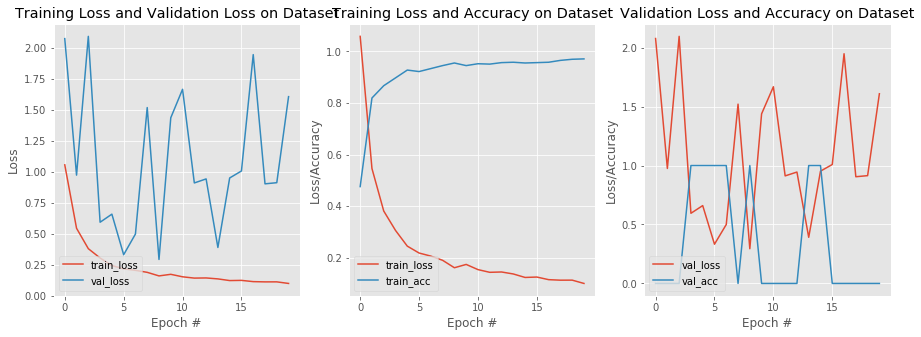

In [12]:
trained_model_l, train_generator,validation_generator = train_model(model)
label_dict_l = get_label_dict(train_generator )

In [13]:
model = create_model('S')

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

Found 693 images belonging to 3 classes.
Found 171 images belonging to 3 classes.
Epoch 1/20
9/9 [==============================] - 11s 1s/step - loss: 2.2800 - acc: 0.4257 - val_loss: 0.3528 - val_acc: 1.0000
Epoch 2/20
9/9 [==============================] - 9s 1s/step - loss: 1.5498 - acc: 0.5123 - val_loss: 0.0308 - val_acc: 1.0000
Epoch 3/20
9/9 [==============================] - 10s 1s/step - loss: 1.0122 - acc: 0.6696 - val_loss: 0.0322 - val_acc: 1.0000
Epoch 4/20
9/9 [==============================] - 10s 1s/step - loss: 0.7616 - acc: 0.7287 - val_loss: 0.0999 - val_acc: 1.0000
Epoch 5/20
9/9 [==============================] - 10s 1s/step - loss: 0.5658 - acc: 0.7994 - val_loss: 0.2316 - val_acc: 1.0000
Epoch 6/20
9/9 [==============================] - 10s 1s/step - loss: 0.4904 - acc: 0.8297 - val_loss: 0.1394 - val_acc: 1.0000
Epoch 7/20
9/9 [==============================] - 10s 1s/step - loss: 0.4593 - acc: 0.8369 - val_loss: 0.3082 - val_acc: 1.0000
Epoch 8/20
9/9 [=======

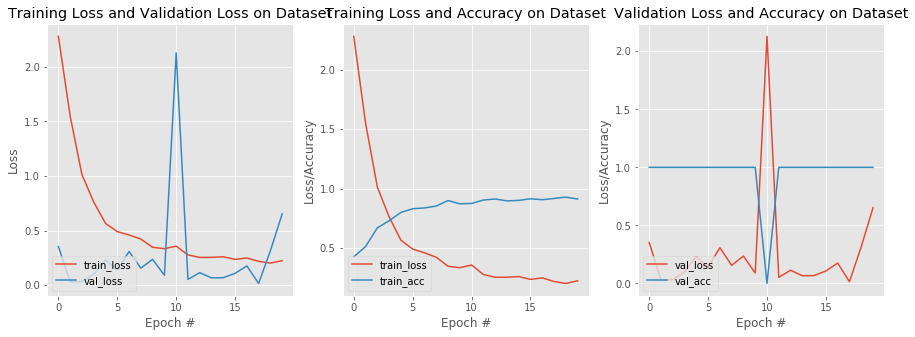

In [14]:
trained_model_s, train_generator,validation_generator = train_model(model)
label_dict_s = get_label_dict(train_generator)

In [15]:
def get_display_string(pred_class, label_dict):
    txt = ""
    for c, confidence in pred_class:
        txt += label_dict[c]
        if c :
            txt += '['+ str(confidence) +']'
    #print("count="+str(len(pred_class)) + " txt:" + txt)
    return txt

In [16]:

def predict(  model, video_path, filename, label_dict ):
    
    vs = cv2.VideoCapture(video_path)
    fps = math.floor(vs.get(cv2.CAP_PROP_FPS))
    ret_val = True
    writer = 0
    
    while True:
        ret_val, frame = vs.read()
        if not ret_val:
            break
       
        resized_frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
        frame_for_pred = prepare_image_for_prediction( resized_frame )
        pred_vec = model.predict(frame_for_pred)
        #print(pred_vec)
        pred_class =[]
        confidence = np.round(pred_vec.max(),2) 
        
        if confidence > 0.4:
            pc = pred_vec.argmax()
            pred_class.append( (pc, confidence) )
        else:
            pred_class.append( (0, 0) )
        if pred_class:
            txt = get_display_string(pred_class, label_dict)       
            frame = draw_prediction( frame, txt )
        #print(pred_class)
        #plt.axis('off')
        #plt.imshow(frame)
        #plt.show()
        #clear_output(wait = True)
        if not writer:
            fourcc = cv2.VideoWriter_fourcc(*"XVID")
            writer = cv2.VideoWriter(filename, fourcc, fps,(frame.shape[1], frame.shape[0]), True)
            
        # write the out
        writer.write(frame)
        
    vs.release()
    writer.release()
      
   

In [17]:
#test_lables = get_test_labels( validation_generator )
#print(test_lables)

In [18]:
#pred_lables, confidence = get_pred_labels( validation_generator )
#print( pred_lables )


In [19]:
video_path = '../input/fire-detection-from-cctv/data/data/video_data/test_videos/test1.mp4'
predict ( trained_model_l, video_path, 'test1_9.avi',  label_dict_l) 

video_path = '../input/fire-detection-from-cctv/data/data/video_data/test_videos/test2.mp4'
predict ( trained_model_l, video_path, 'test2_9.avi',  label_dict_l) 

video_path = '../input/fire-detection-from-cctv/data/data/video_data/test_videos/test3.mp4'
predict ( trained_model_l, video_path, 'test3_9.avi',  label_dict_l) 

## Results:
Below are the three test videos that were passed through the trained model. It can be seen that in case there is both fire and smoke, the model is biased towards predicting it as smoke. If we look at the training vs validtion accuracy, it is clear that the model is overfitting the training data. There is still some work that needs to be done on this.

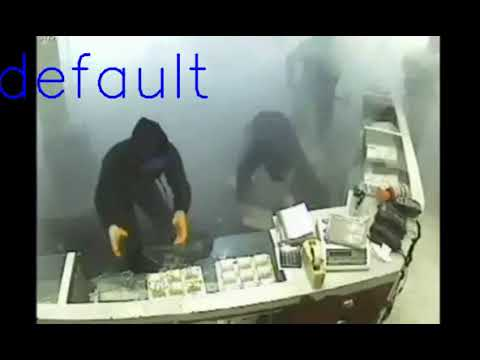

In [20]:
from IPython.display import YouTubeVideo
YouTubeVideo('cHlTG6WL0OY', width=800, height=450)


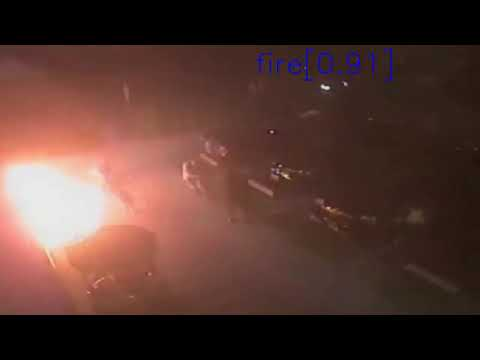

In [21]:
from IPython.display import YouTubeVideo
YouTubeVideo('Lk7_qDy60CI', width=800, height=450)


## References:

[1] https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/  
[2] https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720  
[3] https://www.learnopencv.com/read-write-and-display-a-video-using-opencv-cpp-python/  
[4] https://github.com/bikz05/ipython-notebooks/blob/master/computer-vision/displaying-video-in-ipython-notebook.ipynb
